# Models included

- Raw data
  - Naive Bayes, LightGBM, Isolation Forest

- Normed data
  - SVM, SGD, Naive Bayes, LightGBM, Isolation Forest, one-class SVM



In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yfinance as yf
import talib
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.metrics import Precision, AUC


import scripts.feature as feat
import scripts.utility as util


# Multi ticker

In [12]:
class FirmEncoder:
    def __init__(self, firms):
        self.encoder = LabelEncoder()
        self.encoder.fit(firms)

        self.scaler = StandardScaler()
        self.scaler.fit(self.encoder.transform(firms).reshape(-1, 1))
    
    def encode(self, firm):
        code = self.encoder.transform([firm]).reshape(-1, 1)
        return self.scaler.transform(code)[0][0]

In [13]:
# ticker_list = ["TSLA", "NVDA", "AMZN"]
ticker_list = ["TSLA", "NVDA", "AMZN", "AAPL", "MSFT", "AMD", "GOOG", "META"]


def multi_ticker_dataset_pipeline(ticker_list, normalize=False, extend=None):
    encoder = FirmEncoder(ticker_list)
    X_train, y_train, X_val, y_val = [], [], [], []

    for ticker in ticker_list:
        df = yf.download(ticker, period="5y", interval="1d", progress=False)
        df = df.drop(columns=["Adj Close"])
        firm = encoder.encode(ticker)

        if normalize:
            Xtrain, ytrain, Xval, yval = feat.norm_dataset_pipeline(df,
                                                                    seq_len=None,
                                                                    extend=extend,
                                                                    firm=firm)
        else:
            Xtrain, ytrain, Xval, yval = feat.raw_dataset_pipeline(df, 
                                                                   seq_len=None, 
                                                                   extend=extend,
                                                                   firm=firm)

        X_train.append(Xtrain)
        y_train.append(ytrain)
        X_val.append(Xval)
        y_val.append(yval)

    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)

    return X_train, y_train, X_val, y_val



In [14]:
result_table = pd.DataFrame(columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                     "val_recall", "val_precision", "val_f1", "val_fbeta"])


## Multi-category case


In [15]:
def single_class_report(y_true, y_pred, label):
    instance = np.where(y_true == label)[0]
    predict = np.where(y_pred == label)[0]
    correct = np.intersect1d(instance, predict) 

    precision = len(correct) / (len(predict) + 0.01)
    recall = len(correct) / (len(instance)+ 0.01)
    
    def fbeta_score(b):
        return (1+b**2) * (precision * recall) / (b**2 * precision + recall + 0.01)
    f1 = fbeta_score(b=1)
    fbeta = fbeta_score(b=0.5)  # 0.5 beta focus more on precision

    print(f"----- For Class {label} -----")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"f1_score: {f1}")
    print(f"f0.5_score: {fbeta}")

    return [recall, precision, f1, fbeta]


def quick_model_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train, y_train)

    print("train set")
    y_pred = model.predict(X_train)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)


def quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label):
    model.fit(X_train)

    # class 1 is normal, -1 is anomaly
    print("train set")
    y_pred = model.predict(X_train)
    y_pred = np.where(y_pred > 0, 0, 1)
    train_result = single_class_report(y_train, y_pred, label=label)

    print("val set")
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred > 0, 0, 1)
    val_result = single_class_report(y_val, y_pred, label=label)

    return np.round(train_result + val_result, 3)

def update_result_table(df, result, idx_name):
    new = pd.DataFrame(data=[result],
                       columns=["train_recall", "train_precision", "train_f1", "train_fbeta",
                                "val_recall", "val_precision", "val_f1", "val_fbeta"],
                       index=[idx_name])
    df = pd.concat([df, new])
    return df


In [16]:
class_type = "multi"

### Raw data

In [17]:
data_type = "raw"

In [18]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=False, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7824, 101) (7824,) (1960, 101) (1960,)
(array([0, 1, 2], dtype=int64), array([2052, 3205, 2567], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 406, 1051,  503], dtype=int64))


In [19]:
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import IsolationForest



In [20]:
# Build LightGBM model
params = {
    "objective": "multiclass",
    "num_class": 3,
    "metric": "multi_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
    
}


model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.7498996887429343
Precision: 0.77153999382768
f1_score: 0.7555995940407202
f0.5_score: 0.759061319148202
val set
----- For Class 2 -----
Recall: 0.38369018508578356
Precision: 0.3914727895985883
f1_score: 0.38260659745834563
f0.5_score: 0.38195937768791444


C:\Users\edton\AppData\Local\Temp\ipykernel_39232\408401763.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new])


In [21]:
result_table

,train_recall,train_precision,train_f1,train_fbeta,val_recall,val_precision,val_f1,val_fbeta
multi_raw_LGBMClassifier,0.75,0.772,0.756,0.759,0.384,0.391,0.383,0.382


In [22]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.18542974121643466
Precision: 0.4798338726424129
f1_score: 0.26352810666786824
f0.5_score: 0.3526426646017804
val set
----- For Class 2 -----
Recall: 0.17295878809566412
Precision: 0.5087421788199521
f1_score: 0.2544204357389052
f0.5_score: 0.3546390397789559


### Normed data

In [23]:
data_type = "norm"

In [24]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=True, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7824, 101) (7824,) (1960, 101) (1960,)
(array([0, 1, 2], dtype=int64), array([2052, 3205, 2567], dtype=int64))
(array([0, 1, 2], dtype=int64), array([ 406, 1051,  503], dtype=int64))


In [25]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.7401607317462728
Precision: 0.7599969600121599
f1_score: 0.7449816785590689
f0.5_score: 0.7479045095390628
val set
----- For Class 2 -----
Recall: 0.34591757619132824
Precision: 0.3678569163442633
f1_score: 0.3516238115583117
f0.5_score: 0.35513882063207786


In [26]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.11336145944113968
Precision: 0.4279348833105396
f1_score: 0.17599000448913754
f0.5_score: 0.2632534076752328
val set
----- For Class 2 -----
Recall: 0.059640961412297966
Precision: 0.302999697000303
f1_score: 0.09698991684758124
f0.5_score: 0.15536731510372936


In [27]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.3373574703643538
Precision: 0.4214091415613549
f1_score: 0.36985352844457564
f0.5_score: 0.3925404748251854
val set
----- For Class 2 -----
Recall: 0.25844416611995785
Precision: 0.3571330457954452
f1_score: 0.2950841253692155
f0.5_score: 0.3225184354809089


In [28]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=2)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 2 -----
Recall: 0.46552214444041895
Precision: 0.6393759262925292
f1_score: 0.5339387700538448
f0.5_score: 0.5855750726332576
val set
----- For Class 2 -----
Recall: 0.14512633943659173
Precision: 0.41240607875261287
f1_score: 0.21091653147049752
f0.5_score: 0.2897198271597634


## Binary case

In [29]:
class_type = "binary"

### Raw data

In [30]:
data_type = "raw"

In [31]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=False, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7824, 101) (7824,) (1960, 101) (1960,)
(array([0, 1]), array([5257, 2567], dtype=int64))
(array([0, 1]), array([1457,  503], dtype=int64))


In [32]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.03,
    "num_leaves": 32,
    "verbose": -1,
}
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.43240969065176993
Precision: 0.9495213898940129
f1_score: 0.5899462354275723
f0.5_score: 0.7549798971819548
val set
----- For Class 1 -----
Recall: 0.07554521778891075
Precision: 0.4129985871100967
f1_score: 0.12516480158073587
f0.5_score: 0.2065738671003794


In [33]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.35839361747714266
Precision: 0.4784166488993817
f1_score: 0.4049584193021654
f0.5_score: 0.43919634625451076
val set
----- For Class 1 -----
Recall: 0.27037235840241747
Precision: 0.4641479812975666
f1_score: 0.33711042575872
f0.5_score: 0.39571715188899553


In [34]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")


train set
----- For Class 1 -----
Recall: 0.6151125239091394
Precision: 0.40362882507969045
f1_score: 0.4826813767353387
f0.5_score: 0.427462806789037
val set
----- For Class 1 -----
Recall: 0.6182779666408222
Precision: 0.3578785054257143
f1_score: 0.448749059417293
f0.5_score: 0.3853520318247773


### Normed data

In [35]:
data_type = "norm"

In [36]:
X_train, y_train, X_val, y_val = multi_ticker_dataset_pipeline(ticker_list, normalize=True, extend=3)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

y_train = np.where(y_train <= 1, 0, 1)
y_val = np.where(y_val <= 1, 0, 1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(7824, 101) (7824,) (1960, 101) (1960,)
(array([0, 1]), array([5257, 2567], dtype=int64))
(array([0, 1]), array([1457,  503], dtype=int64))


In [37]:
model = lgb.LGBMClassifier(**params)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.40630928590071713
Precision: 0.9387854294740822
f1_score: 0.5629676407646714
f0.5_score: 0.7324000210430215
val set
----- For Class 1 -----
Recall: 0.05566489731814477
Precision: 0.38350910834132307
f1_score: 0.09505445492131864
f0.5_score: 0.1651890227368212


In [38]:
model = GaussianNB()
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.3147630901320992
Precision: 0.40460488430203156
f1_score: 0.34921929157707843
f0.5_score: 0.37376850317718696
val set
----- For Class 1 -----
Recall: 0.1948271406135067
Precision: 0.34264536205027796
f1_score: 0.24387203305343783
f0.5_score: 0.2872601689486703


In [39]:
model = SGDClassifier(loss="log_loss")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.28320886946291596
Precision: 0.42966649133279355
f1_score: 0.3366703801399797
f0.5_score: 0.3796730475107814
val set
----- For Class 1 -----
Recall: 0.1968151726605833
Precision: 0.34857927537762756
f1_score: 0.24705212848879157
f0.5_score: 0.2917305596507686


In [40]:
model = SVC(kernel="rbf")
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.13946186419219245
Precision: 0.8972206210370668
f1_score: 0.2390945910862331
f0.5_score: 0.41846944048576046
val set
----- For Class 1 -----
Recall: 0.003976064094153198
Precision: 0.9950248756218907
f1_score: 0.00784198017072777
f0.5_score: 0.018822785287272277


In [41]:
model = SVC(kernel="rbf", C=10)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.4756506597169469
Precision: 0.9487105772293921
f1_score: 0.6292066465771172
f0.5_score: 0.7803630707100098
val set
----- For Class 1 -----
Recall: 0.11331782668336614
Precision: 0.513467255202234
f1_score: 0.1827460946801626
f0.5_score: 0.28897767321396606


In [42]:
model = SVC(kernel="sigmoid", C=10)
model_result = quick_model_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.34982333532008053
Precision: 0.35077987976609465
f1_score: 0.3453713264949719
f0.5_score: 0.3427541009501816
val set
----- For Class 1 -----
Recall: 0.23657581360211527
Precision: 0.2319642891951424
f1_score: 0.2293523160219944
f0.5_score: 0.22522614482797443


In [43]:
# This wont be good enough as contamination too low in train
model = IsolationForest(contamination=0.5)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.5590161316083693
Precision: 0.36681910322315125
f1_score: 0.43823482692607507
f0.5_score: 0.3879432938000733
val set
----- For Class 1 -----
Recall: 0.49303194767499653
Precision: 0.3258827085058015
f1_score: 0.38766496717166005
f0.5_score: 0.34360535708200973


In [44]:
model = OneClassSVM(kernel="rbf", nu=0.4)
model_result = quick_unsupervised_evaluation(model, X_train, y_train, X_val, y_val, label=1)
result_table = update_result_table(result_table, model_result, f"{class_type}_{data_type}_{model.__class__.__name__}")

train set
----- For Class 1 -----
Recall: 0.4534458377645587
Precision: 0.3721215725013667
f1_score: 0.40388597286111344
f0.5_score: 0.37903006639499226
val set
----- For Class 1 -----
Recall: 0.3598338005208644
Precision: 0.3255337134224205
f1_score: 0.3369097087501083
f0.5_score: 0.32450565326963765


# Final results in heatmap

<Axes: >

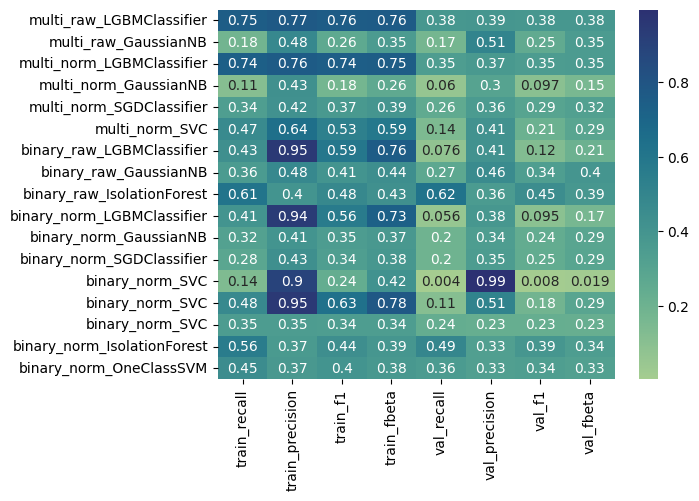

In [45]:
sns.heatmap(result_table, annot=True, cmap="crest")


<Axes: >

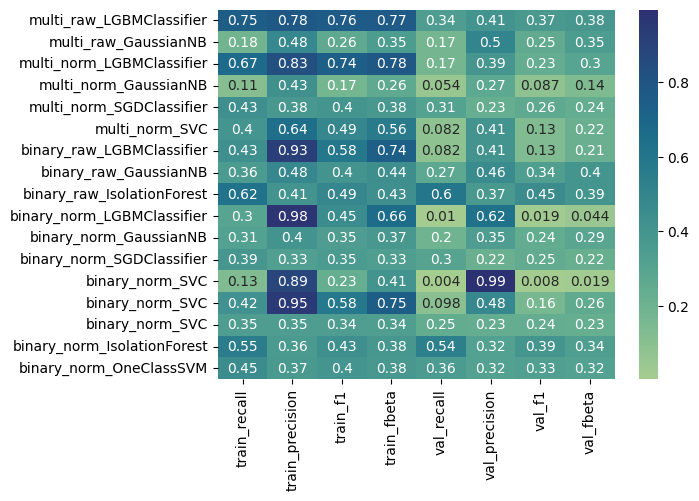

In [34]:
sns.heatmap(result_table, annot=True, cmap="crest")
